In [1]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from homodyne import *
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from scipy.special import comb
import sqtdiat.qops as sq
from qutip import fidelity, Qobj
from tqdm import tqdm
import seaborn as sns

plt.style.use("ggplot")

def d_s(li):
    if type(li) != np.array:
        li = np.array(li, dtype = 'complex128')
    if sum(np.abs(li)**2) != 1:
        li /= np.sqrt(np.sum(np.abs(li)**2))
    return np.outer(li, li.conjugate().T)

def gaussian(x, amplitude, mean, stddev, offset):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2) + offset

In [2]:
def den_2_prob(rho, xv = np.linspace(-10, 10, 1000), theta = 0):
    prob_ = np.zeros_like(xv, dtype = 'complex128')
    if type(rho) != np.array: rho = np.array(rho)
    for n in range(rho.shape[0]):
        for m in range(n + 1):
            if np.abs(rho[n, m]) > 1e-7: 
                elem = rho[n, m]
                # + np.arctan(np.real(elem) / np.imag(elem))
                prob_ += elem * quad(n, m, xv, theta)
                if m != n:
                    prob_ += elem.conjugate() * quad(n, m, xv, theta)
    return np.abs(prob_)
q, theta = sm.symbols('q theta')
n = sm.symbols('n', integer = True)
m = sm.symbols('m', integer = True)

n_xtheta = sm.exp(-q**2 / 2) * sm.hermite(n, q) / sm.sqrt(2**n * sm.factorial(n)) * (1 / sm.pi) ** (1 / 4) * sm.exp(1j * (n * theta - sm.pi / 2))
nxt = sm.lambdify((n, q, theta), n_xtheta)

def quad(n, m, q, theta):
    return nxt(n, q, theta) * nxt(m, q, theta).conjugate()

def get_data(rho, pts = 10, angles = 360, xv = np.linspace(-10, 10, 1000)):
    data = np.zeros((pts * angles))
    thetas = np.linspace(0, 2 * np.pi, angles)
    for angle, th in zip(thetas, range(angles)):
        prob = den_2_prob(rho, xv, theta = angle)
        data[th * pts: (th + 1) * pts] = np.random.choice(a = xv, p = prob / np.sum(prob), size = (pts))
    return data

def B(n, k, eta):
    return np.sqrt(comb(n + k, n) * eta ** n * (1 - eta) ** k)

def R_(data, theta_data, den = np.eye(10)):
    R_mat = np.zeros_like(den)
    N, M = np.mgrid[:den.shape[0], :den.shape[0]]
    for th, q in zip(theta_data, data):
        op = quad(N, M, q, th - np.pi / 2)
        R_mat += op / np.trace(op @ den)
    return R_mat

def perform_MLE(data, theta_data, dims, iters = 20):
    # global fid
    fid = []
    global MK
    rho = np.eye(dims, dtype = 'complex128')
    R = R_(data, theta_data, rho)
    for item in tqdm(range(iters), desc = "MLE in progress"):
        rho = R @ rho @ R
        rho /= np.trace(rho)
        R = R_(data, theta_data, rho)
    return rho.T

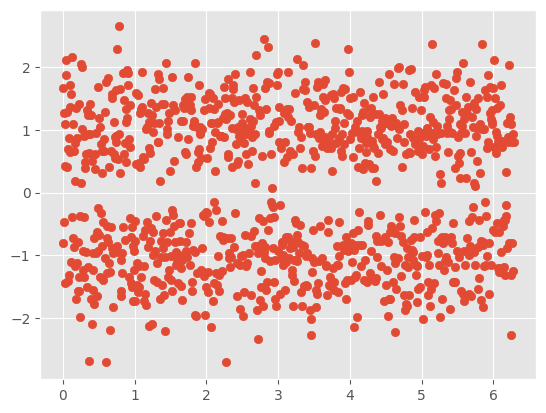

In [3]:
test_rho = np.zeros((15, 15))
test_rho[1, 1] = 1
theta_data = np.linspace(0, 2 * np.pi, 1000)
data = get_data(test_rho, pts = 1, angles = 1000)

plt.scatter(theta_data, data)

In [4]:
rho = perform_MLE(data, theta_data, dims = 3, iters = 40)

MLE in progress: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.20it/s]


Text(0, 0.5, 'P(n)')

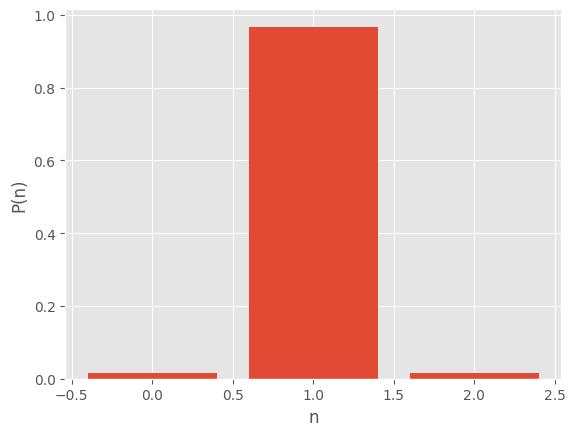

In [11]:
plt.bar(range(3), np.diag(np.real(rho)))
plt.xlabel("n")
plt.ylabel('P(n)')

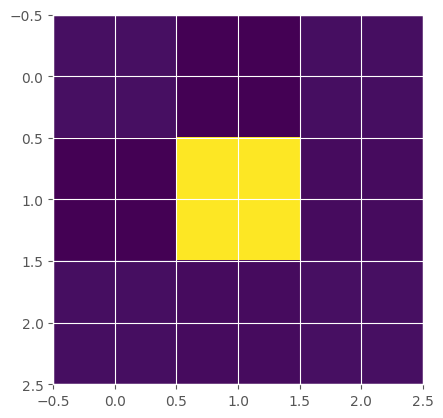

In [12]:
plt.imshow(np.real(rho))

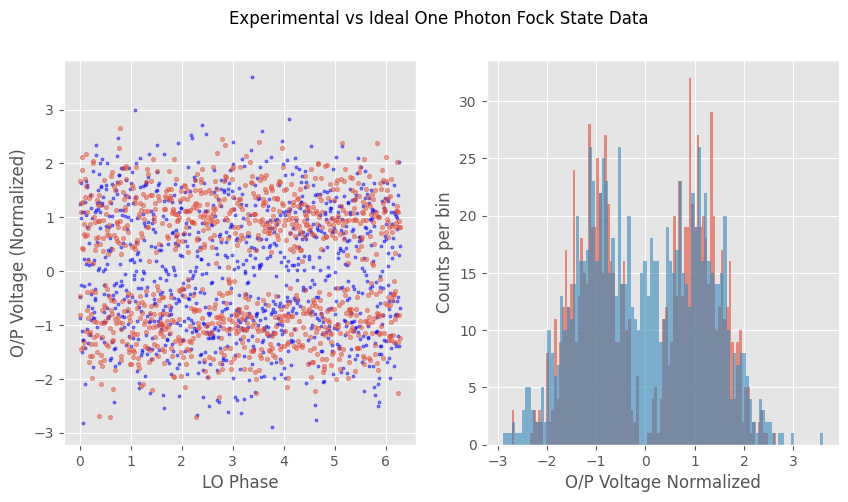

In [14]:
# Experimental data courtesy of Lvovsky and Team

data_one = np.loadtxt("ONEPHOTONFOCK_qnoise.txt")[::10] / 50
theta_data_one = np.linspace(0, 2 * np.pi, 1000)
plt.figure(figsize = (10, 5))
plt.suptitle("Experimental vs Ideal One Photon Fock State Data")
plt.subplot(1, 2, 1)
plt.scatter(theta_data_one, data_one, s = 5, color = "blue", alpha = 0.5)
plt.scatter(theta_data, data, s = 10, alpha = 0.5)
plt.xlabel("LO Phase")
plt.ylabel("O/P Voltage (Normalized)")
plt.subplot(1, 2, 2)
plt.hist(data, bins = 100, alpha = 0.6)
plt.hist(data_one, bins = 100, alpha = 0.6)
plt.xlabel("O/P Voltage Normalized")
plt.ylabel("Counts per bin")
plt.show()

In [15]:
dims_one = 15
rho_one = perform_MLE(data_one, theta_data_one, iters = 30, dims = dims_one)

MLE in progress: 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.20it/s]


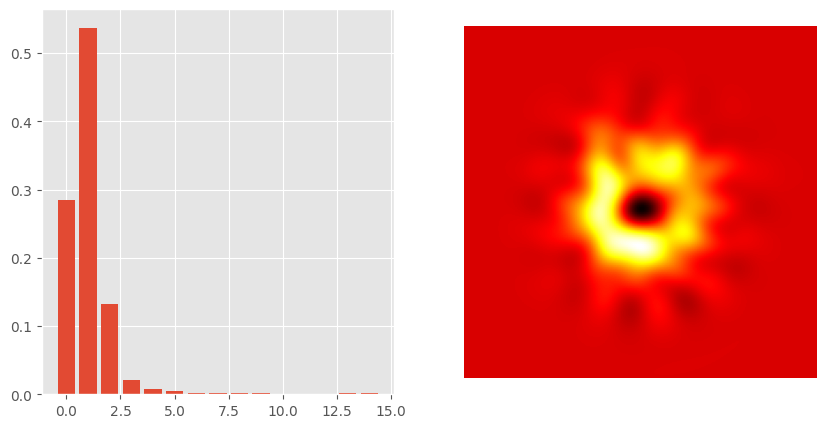

In [16]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(dims_one), np.diag(np.real(rho_one)))
plt.subplot(1, 2, 2)
plt.imshow(wigner_laguerre(rho_one, x_max = 5, x_min = -5, p_max = 5, p_min = -5), cmap = 'hot')
plt.axis('off')
plt.show()

In [17]:
fidelity(Qobj(rho_one), Qobj(test_rho))

0.7332117057557873